# Advanced ML: Classification : Ensembles

__Ensembling__
The process of combining several predictive models in order to produce a combined model that is more accurate than any individual model.

Models used for ensembling must have the following characteristics:

- **Accurate:** they outperform random guessing
- **Independent:** their predictions are generated using different processes

### Why Ensembles Work?

If you have a collection of individually imperfect (and independent) models, the "one-off" mistakes made by each model are probably not going to be made by the rest of the models, and thus the mistakes will be discarded when averaging the models.

**Note:** As you add more models to the voting process, the probability of error decreases, which is known as [Condorcet's Jury Theorem](http://en.wikipedia.org/wiki/Condorcet%27s_jury_theorem).

- **Regression:** take the average of the predictions
- **Classification:** take a vote and use the most common prediction, or take the average of the predicted probabilities

### Ensembling methods

Following are basic methods for ensembling:

- Manual Ensemble of models
- Bagging
- Boosting

### What makes a good "manual ensemble"?

- Different types of models
- Different combinations of features
- Different tuning parameters

## Bagging: Improving upon Decision Trees

<img src="https://github.com/dipanjanS/appliedml_workshop_dhs_av_2019/blob/master/Module%2008%20-%20%20Advanced%20ML%20-%20Supervised%20Models/assets/bagging_001.png?raw=1">

__Decision Trees__ are highly dependent upon the training datasets, i.e. they have __high variance__. Decision trees also have a tendency to easily __overfit__ on the training data.

Bagging or __Bootstrap Aggregation__, refers to the aggregation of bootstrapped samples.
__Bagging__ is a general purpose procedure for reducing the variance of a machine learning method, and is highly effective with decision trees as well. 

### What is a __bootstrap sample__? 
A random sample with replacement

### Bagging for Decision Trees

+ Bagging utilizes multiple trees, where number of trees is a hyperparameter
+ Grow N trees using N bootstrap samples from training data
+ Each of the N samples are of the same size
+ The trees are **grown deep** so that they have low bias/high variance.
+ Combine thee predictions as:
    - Regression: average of predicted values
    - Classification: majority vote from N trees

## Bagging: Hands-on

### Introduction

We will be using the customer churn data from the telecom industry that we used in week 1 for this week's exercises. The data file is called `Orange_Telecom_Churn_Data.csv`. 

### Question 1

* Import the customer churn data, which is found in the file `Orange_Telecom_Churn_Data.csv`. 
* Remove any columns that are likely not to be used for prediction.
* Encode data types as appropriate.

In [0]:
import pandas as pd
import numpy as np

data = pd.read_csv('https://raw.githubusercontent.com/dipanjanS/appliedml_workshop_dhs_av_2019/master/Module%2008%20-%20%20Advanced%20ML%20-%20Supervised%20Models/data/Orange_Telecom_Churn_Data.csv')

In [2]:
data.head()

,state,account_length,area_code,phone_number,intl_plan,voice_mail_plan,number_vmail_messages,total_day_minutes,total_day_calls,total_day_charge,total_eve_minutes,total_eve_calls,total_eve_charge,total_night_minutes,total_night_calls,total_night_charge,total_intl_minutes,total_intl_calls,total_intl_charge,number_customer_service_calls,churned
0,KS,128,415,382-4657,no,yes,25,265.1,110,45.07,197.4,99,16.78,244.7,91,11.01,10.0,3,2.70,1,False
1,OH,107,415,371-7191,no,yes,26,161.6,123,27.47,195.5,103,16.62,254.4,103,11.45,13.7,3,3.70,1,False
2,NJ,137,415,358-1921,no,no,0,243.4,114,41.38,121.2,110,10.30,162.6,104,7.32,12.2,5,3.29,0,False
3,OH,84,408,375-9999,yes,no,0,299.4,71,50.90,61.9,88,5.26,196.9,89,8.86,6.6,7,1.78,2,False
4,OK,75,415,330-6626,yes,no,0,166.7,113,28.34,148.3,122,12.61,186.9,121,8.41,10.1,3,2.73,3,False


### Drop Columns

The prediction should definitely not include phone number. And it is unlikely that area code or state would be desired, unless there is some reason to assume the model has a very specific geographic factor.

In [0]:
data.drop(['state', 'phone_number', 'area_code'], axis=1, inplace=True)

### Prepare Columns

In [4]:
data.dtypes

account_length                     int64
intl_plan                         object
voice_mail_plan                   object
number_vmail_messages              int64
total_day_minutes                float64
total_day_calls                    int64
total_day_charge                 float64
total_eve_minutes                float64
total_eve_calls                    int64
total_eve_charge                 float64
total_night_minutes              float64
total_night_calls                  int64
total_night_charge               float64
total_intl_minutes               float64
total_intl_calls                   int64
total_intl_charge                float64
number_customer_service_calls      int64
churned                             bool
dtype: object

In [5]:
for col in ['intl_plan', 'voice_mail_plan']:
    data[col] = data[col].replace('yes','True').replace('no','False').astype(np.bool)
    
    
data[['intl_plan', 'voice_mail_plan']].dtypes

intl_plan          bool
voice_mail_plan    bool
dtype: object

### Question 2

* Examine distribution of the predicted variable (`churned`).
* Split the data into train and test sets. Decide if a stratified split should be used or not based on the distribution.
* Examine the distribution of the predictor variable in the train and test data.

In [6]:
# Data are skewed at ~85% towards non-churned customers
# This will be important to remember when model building

data.churned.value_counts()

False    4293
True      707
Name: churned, dtype: int64

In [7]:
data.churned.value_counts(normalize=True)

False    0.8586
True     0.1414
Name: churned, dtype: float64

In [0]:
from sklearn.model_selection import StratifiedShuffleSplit


feature_cols = [x for x in data.columns if x != 'churned']


# Split the data into two parts with 1500 points in the test data
# This creates a generator
strat_shuff_split = StratifiedShuffleSplit(n_splits=1, test_size=1500, random_state=42)

# Get the index values from the generator
train_idx, test_idx = next(strat_shuff_split.split(data[feature_cols], data['churned']))

# Create the data sets
X_train = data.loc[train_idx, feature_cols]
y_train = data.loc[train_idx, 'churned']

X_test = data.loc[test_idx, feature_cols]
y_test = data.loc[test_idx, 'churned']

### Question 4

* Fit random forest models with a range of tree numbers and evaluate the out-of-bag error for each of these models.
* Plot the resulting oob errors as a function of the number of trees.

*Hint:* since the only thing changing is the number of trees, the `warm_start` flag can be used so that the model just adds more trees to the existing model each time. Use the `set_params` method to update the number of trees.

In [0]:
# Suppress warnings about too few trees from the early models

import warnings
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=RuntimeWarning)

In [20]:
from sklearn.ensemble import RandomForestClassifier

# Initialize the random forest estimator
# Note that the number of trees is not setup here
rf = RandomForestClassifier(oob_score=True, 
                            random_state=42, 
                            warm_start=True,
                            n_jobs=1)

oob_list = list()

# Iterate through all of the possibilities for 
# number of trees
for n_trees in [15, 20, 30, 40, 50, 100, 150, 200, 300, 400]:
    
    # Use this to set the number of trees
    rf.set_params(n_estimators=n_trees)

    # Fit the model
    rf.fit(X_train, y_train)

    # Get the oob error
    oob_error = 1 - rf.oob_score_
    
    # Store it
    oob_list.append(pd.Series({'n_trees': n_trees, 'oob': oob_error}))

rf_oob_df = pd.concat(oob_list, axis=1).T.set_index('n_trees')

rf_oob_df

,oob
n_trees,
15.0,0.092286
20.0,0.084857
30.0,0.080857
40.0,0.077429
50.0,0.077714
100.0,0.072857
150.0,0.072571
200.0,0.073143
300.0,0.072000


In [0]:
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

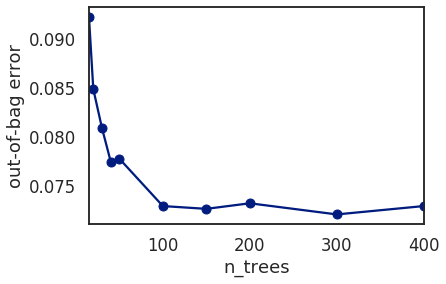

In [22]:
sns.set_context('talk')
sns.set_palette('dark')
sns.set_style('white')

ax = rf_oob_df.plot(legend=False, marker='o')
ax.set(ylabel='out-of-bag error');

### Question 4

* Select one of the models that performs well and calculate error metrics and a confusion matrix on the test data set. 
* Given the distribution of the predicted class, which metric is most important? Which could be deceiving?

In [23]:
rf

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=400, n_jobs=1,
                       oob_score=True, random_state=42, verbose=0,
                       warm_start=True)

In [0]:
# Random forest with 300 estimators
model = RandomForestClassifier(oob_score=False, 
                              random_state=42, 
                              n_estimators=300,
                              n_jobs=1)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

In [25]:
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score
from sklearn.metrics import f1_score, roc_auc_score

cr = classification_report(y_test, y_pred)
print(cr)

score_df = pd.DataFrame({'accuracy': accuracy_score(y_test, y_pred),
                         'precision': precision_score(y_test, y_pred),
                         'recall': recall_score(y_test, y_pred),
                         'f1': f1_score(y_test, y_pred),
                         'auc': roc_auc_score(y_test, y_pred)},
                         index=pd.Index([0]))

print(score_df)

              precision    recall  f1-score   support

       False       0.93      1.00      0.96      1288
        True       0.95      0.55      0.69       212

    accuracy                           0.93      1500
   macro avg       0.94      0.77      0.83      1500
weighted avg       0.93      0.93      0.92      1500

   accuracy  precision   recall        f1       auc
0     0.932    0.95082  0.54717  0.694611  0.771256


### Question 5

* Print or visualize the confusion matrix.
* Plot the ROC-AUC and precision-recall curves.
* Plot the feature importances.

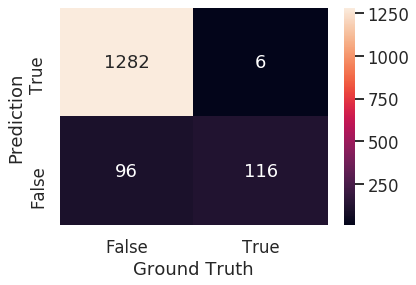

In [27]:
from sklearn.metrics import roc_curve, precision_recall_curve, confusion_matrix

sns.set_context('talk')
cm = confusion_matrix(y_test, y_pred)
ax = sns.heatmap(cm, annot=True, fmt='d')

labels = ['False', 'True']
ax.set_xticklabels(labels);
ax.set_yticklabels(labels[::-1]);
ax.set_ylabel('Prediction');
ax.set_xlabel('Ground Truth');
# This has to be done for a bug in seaborn\matplotlib which should get fixed with matplotlib 3.1.2
b, t = ax.get_ylim() # discover the values for bottom and top
b += 0.5 # Add 0.5 to the bottom
t -= 0.5 # Subtract 0.5 from the top
ax.set_ylim(b, t); # update the ylim(bottom, top) values

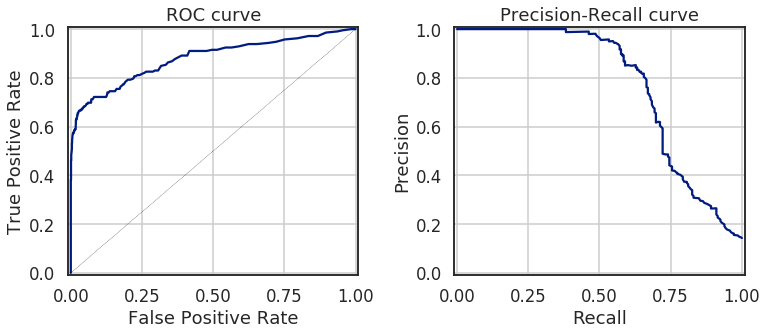

In [28]:
sns.set_context('talk')

fig, axList = plt.subplots(ncols=2)
fig.set_size_inches(11, 5)

# Get the probabilities for each of the two categories
y_prob = model.predict_proba(X_test)

# Plot the ROC-AUC curve
ax = axList[0]

fpr, tpr, thresholds = roc_curve(y_test, y_prob[:,1])
ax.plot(fpr, tpr)
# It is customary to draw a diagonal dotted line in ROC plots.
# This is to indicate completely random prediction. Deviation from this
# dotted line towards the upper left corner signifies the power of the model.
ax.plot([0, 1], [0, 1], ls='--', color='black', lw=.3)
ax.set(xlabel='False Positive Rate',
       ylabel='True Positive Rate',
       xlim=[-.01, 1.01], ylim=[-.01, 1.01],
       title='ROC curve')
ax.grid(True)

# Plot the precision-recall curve
ax = axList[1]

precision, recall, _ = precision_recall_curve(y_test, y_prob[:,1])
ax.plot(recall, precision)
ax.set(xlabel='Recall', ylabel='Precision',
       xlim=[-.01, 1.01], ylim=[-.01, 1.01],
       title='Precision-Recall curve')
ax.grid(True)

plt.tight_layout()

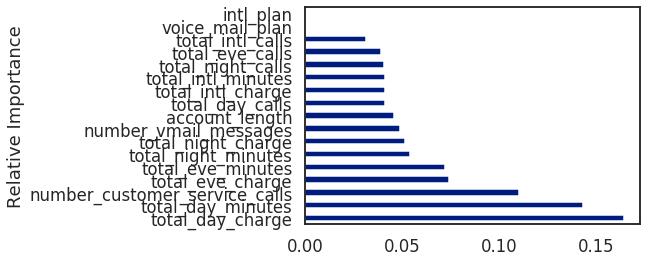

In [29]:
feature_imp = pd.Series(model.feature_importances_, index=feature_cols).sort_values(ascending=False)

ax = feature_imp.plot(kind='barh')
ax.set(ylabel='Relative Importance');

## Boosting

<img src="https://github.com/dipanjanS/appliedml_workshop_dhs_av_2019/blob/master/Module%2008%20-%20%20Advanced%20ML%20-%20Supervised%20Models/assets/boosting_001.png?raw=1">

### Boosting Approach


+ Boosting is a sequential process which converts multiple weak learners into an ensemble which is itself a strong learner
+ Boosting utilizes different loss functions
+ At each stage, the margin is determined for each point
+ Margin is positive for correctly classified points and negative for mis-classifications
+ Value of loss function is calculated from margin

### Boosting Algorithms

+ __Adaboost__ or Adaptive Boosting
+ __GBM__ or Gradient Boosting Machines
+ __XGBoost__ or Extreme Boosting

### Bagging Vs Boosting
<img src="https://github.com/dipanjanS/appliedml_workshop_dhs_av_2019/blob/master/Module%2008%20-%20%20Advanced%20ML%20-%20Supervised%20Models/assets/bagging_vs_boosting.png?raw=1">

## Boosting: Hands-on 

### Question 1
+ Continue with existing dataset (use same split for ease)
+ Instantiate AdaBoost classifier.


__Hint__: You may use decision tree as the base classifier 

In [0]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier

In [0]:
dt = DecisionTreeClassifier() 

In [33]:
clf_ada = AdaBoostClassifier(base_estimator=dt)
clf_ada.fit(X_train,y_train)

AdaBoostClassifier(algorithm='SAMME.R',
                   base_estimator=DecisionTreeClassifier(class_weight=None,
                                                         criterion='gini',
                                                         max_depth=None,
                                                         max_features=None,
                                                         max_leaf_nodes=None,
                                                         min_impurity_decrease=0.0,
                                                         min_impurity_split=None,
                                                         min_samples_leaf=1,
                                                         min_samples_split=2,
                                                         min_weight_fraction_leaf=0.0,
                                                         presort=False,
                                                         random_state=None,
                          

In [34]:
clf_ada

AdaBoostClassifier(algorithm='SAMME.R',
                   base_estimator=DecisionTreeClassifier(class_weight=None,
                                                         criterion='gini',
                                                         max_depth=None,
                                                         max_features=None,
                                                         max_leaf_nodes=None,
                                                         min_impurity_decrease=0.0,
                                                         min_impurity_split=None,
                                                         min_samples_leaf=1,
                                                         min_samples_split=2,
                                                         min_weight_fraction_leaf=0.0,
                                                         presort=False,
                                                         random_state=None,
                          

### Question 2
+ Observe model performance

In [0]:
y_pred = clf_ada.predict(X_test)

In [36]:
cr = classification_report(y_test, y_pred)
print(cr)

score_df = pd.DataFrame({'accuracy': accuracy_score(y_test, y_pred),
                         'precision': precision_score(y_test, y_pred),
                         'recall': recall_score(y_test, y_pred),
                         'f1': f1_score(y_test, y_pred),
                         'auc': roc_auc_score(y_test, y_pred)},
                         index=pd.Index([0]))

print(score_df)

              precision    recall  f1-score   support

       False       0.93      0.93      0.93      1288
        True       0.58      0.59      0.59       212

    accuracy                           0.88      1500
   macro avg       0.76      0.76      0.76      1500
weighted avg       0.88      0.88      0.88      1500

   accuracy  precision   recall        f1       auc
0     0.882   0.580645  0.59434  0.587413  0.761844


### Question 3

* Create an AdaBoost model and fit it using grid search, similar to question 2. Try a range of estimators between 100 and 200.
* Compare the errors from AdaBoost to those from the Grid Searched best estimator.

**NOTE:** Setting `max_features=4` in the decision tree classifier used as the base classifier for AdaBoost will increase the convergence rate.

In [0]:
from sklearn.model_selection import GridSearchCV

In [39]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier

abc = AdaBoostClassifier(DecisionTreeClassifier(max_features=4))

param_grid = {'n_estimators': [100, 150, 200],
              'learning_rate': [0.01, 0.001]}

gv_abc = GridSearchCV(abc,
                      param_grid=param_grid, 
                      scoring='recall',
                      n_jobs=1,
                      verbose=2,
                      cv=5)

gv_abc = gv_abc.fit(X_train, y_train)

Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV] learning_rate=0.01, n_estimators=100 ............................
[CV] ............. learning_rate=0.01, n_estimators=100, total=   0.0s
[CV] learning_rate=0.01, n_estimators=100 ............................
[CV] ............. learning_rate=0.01, n_estimators=100, total=   0.0s
[CV] learning_rate=0.01, n_estimators=100 ............................
[CV] ............. learning_rate=0.01, n_estimators=100, total=   0.0s
[CV] learning_rate=0.01, n_estimators=100 ............................
[CV] ............. learning_rate=0.01, n_estimators=100, total=   0.0s
[CV] learning_rate=0.01, n_estimators=100 ............................
[CV] ............. learning_rate=0.01, n_estimators=100, total=   0.0s
[CV] learning_rate=0.01, n_estimators=150 ............................
[CV] ............. learning_rate=0.01, n_estimators=150, total=   0.0s
[CV] learning_rate=0.01, n_estimators=150 ............................
[CV] ............

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


[CV] learning_rate=0.01, n_estimators=200 ............................
[CV] ............. learning_rate=0.01, n_estimators=200, total=   0.0s
[CV] learning_rate=0.01, n_estimators=200 ............................
[CV] ............. learning_rate=0.01, n_estimators=200, total=   0.0s
[CV] learning_rate=0.01, n_estimators=200 ............................
[CV] ............. learning_rate=0.01, n_estimators=200, total=   0.0s
[CV] learning_rate=0.001, n_estimators=100 ...........................
[CV] ............ learning_rate=0.001, n_estimators=100, total=   0.0s
[CV] learning_rate=0.001, n_estimators=100 ...........................
[CV] ............ learning_rate=0.001, n_estimators=100, total=   0.0s
[CV] learning_rate=0.001, n_estimators=100 ...........................
[CV] ............ learning_rate=0.001, n_estimators=100, total=   0.0s
[CV] learning_rate=0.001, n_estimators=100 ...........................
[CV] ............ learning_rate=0.001, n_estimators=100, total=   0.0s
[CV] l

[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:    0.5s finished


In [40]:
# The best model
gv_abc.best_estimator_

AdaBoostClassifier(algorithm='SAMME.R',
                   base_estimator=DecisionTreeClassifier(class_weight=None,
                                                         criterion='gini',
                                                         max_depth=None,
                                                         max_features=4,
                                                         max_leaf_nodes=None,
                                                         min_impurity_decrease=0.0,
                                                         min_impurity_split=None,
                                                         min_samples_leaf=1,
                                                         min_samples_split=2,
                                                         min_weight_fraction_leaf=0.0,
                                                         presort=False,
                                                         random_state=None,
                             

In [41]:
y_pred = gv_abc.predict(X_test)
cr = classification_report(y_test, y_pred)
print(cr)

score_df = pd.DataFrame({'accuracy': accuracy_score(y_test, y_pred),
                         'precision': precision_score(y_test, y_pred),
                         'recall': recall_score(y_test, y_pred),
                         'f1': f1_score(y_test, y_pred),
                         'auc': roc_auc_score(y_test, y_pred)},
                         index=pd.Index([0]))

print(score_df)

              precision    recall  f1-score   support

       False       0.93      0.92      0.92      1288
        True       0.52      0.56      0.54       212

    accuracy                           0.86      1500
   macro avg       0.72      0.74      0.73      1500
weighted avg       0.87      0.86      0.87      1500

   accuracy  precision    recall        f1       auc
0  0.864667   0.519824  0.556604  0.537585  0.735988


### Question 4
* Fit gradient boosted tree models with all parameters set to their defaults the following tree numbers (`n_estimators = [25, 50, 100, 200, 400]`) and evaluate the accuracy on the test data for each of these models. 
* Plot the accuracy as a function of estimator number.

**Note:** This question may take some time to execute, depending on how many different values are fit for estimators. Setting `max_features=4` in the gradient boosting classifier will increase the convergence rate.

Also, there is no such thing as out-of-bag error for boosted models. And the `warm_flag=True` setting has a bug in the gradient boosted model, so don't use it. Simply create the model inside the `for` loop and set the number of estimators at this time. This will make the fitting take a little longer. Additionally, boosting models tend to take longer to fit than bagged ones because the decision stumps must be fit successively.

In [43]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score

error_list = list()

# Iterate through all of the possibilities for number of estimators
tree_list = [15, 50, 100, 200, 400]
for n_trees in tree_list:
    
    # Initialize the gradient boost classifier
    gbc = GradientBoostingClassifier(n_estimators=n_trees, 
                                     subsample=0.9,
                                     max_features=4,
                                     random_state=42)

    # Fit the model
    gbc.fit(X_train.values, y_train.values)
    y_pred = gbc.predict(X_test)

    # Get the error
    error = 1. - accuracy_score(y_test, y_pred)
    
    # Store it
    error_list.append(pd.Series({'n_trees': n_trees, 'error': error}))

error_df = pd.concat(error_list, axis=1).T.set_index('n_trees')

error_df

,error
n_trees,
15.0,0.112667
50.0,0.080000
100.0,0.080000
200.0,0.076667
400.0,0.075333


In [0]:
y_pred = gbc.predict(X_test)

In [48]:
cr = classification_report(y_test, y_pred)
print(cr)

score_df = pd.DataFrame({'accuracy': accuracy_score(y_test, y_pred),
                         'precision': precision_score(y_test, y_pred),
                         'recall': recall_score(y_test, y_pred),
                         'f1': f1_score(y_test, y_pred),
                         'auc': roc_auc_score(y_test, y_pred)},
                         index=pd.Index([0]))

print(score_df)

              precision    recall  f1-score   support

       False       0.93      0.98      0.96      1288
        True       0.85      0.57      0.68       212

    accuracy                           0.92      1500
   macro avg       0.89      0.78      0.82      1500
weighted avg       0.92      0.92      0.92      1500

   accuracy  precision    recall       f1       auc
0  0.924667   0.846154  0.570755  0.68169  0.776837


In [0]:
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

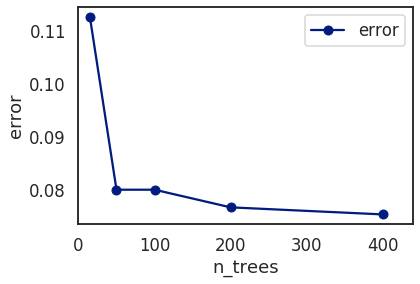

In [50]:
sns.set_context('talk')
sns.set_style('white')
sns.set_palette('dark')

# Create the plot
ax = error_df.plot(marker='o')

# Set parameters
ax.set(xlabel='n_trees', ylabel='error')
ax.set_xlim(0, max(error_df.index)*1.1);

In [51]:
gbc.get_params()

{'criterion': 'friedman_mse',
 'init': None,
 'learning_rate': 0.1,
 'loss': 'deviance',
 'max_depth': 3,
 'max_features': 4,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 400,
 'n_iter_no_change': None,
 'presort': 'auto',
 'random_state': 42,
 'subsample': 0.9,
 'tol': 0.0001,
 'validation_fraction': 0.1,
 'verbose': 0,
 'warm_start': False}

In [53]:
y_pred = gbc.predict(X_test)
print(classification_report(y_pred, y_test))

              precision    recall  f1-score   support

       False       0.98      0.93      0.96      1357
        True       0.57      0.85      0.68       143

    accuracy                           0.92      1500
   macro avg       0.78      0.89      0.82      1500
weighted avg       0.94      0.92      0.93      1500



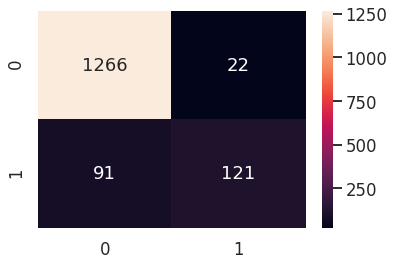

In [55]:
from sklearn.metrics import confusion_matrix

sns.set_context('talk')
cm = confusion_matrix(y_test, y_pred)
ax = sns.heatmap(cm, annot=True, fmt='d')
# This has to be done for a bug in seaborn\matplotlib which should get fixed with matplotlib 3.1.2
b, t = ax.get_ylim() # discover the values for bottom and top
b += 0.5 # Add 0.5 to the bottom
t -= 0.5 # Subtract 0.5 from the top
ax.set_ylim(b, t); # update the ylim(bottom, top) values